# Advanced Example
In this advanced example two input files, a spectrum file and a manually created Settings object are used to generate a basic data set for an Earth-like planet orbiting a Sun-like star 10 pc away. The Settings object will overwrite the settings specified in the config file. The code is run on GPU #0 in detailed mode, thus also saving and outputting the intensity responses.

## Import modules and specify paths


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from phringe.api import PHRINGE
from phringe.core.entities.simulation import Simulation

config_file_path = Path('../_static/config.py')

## Create Simulation Object
Note: passing a ``Simulation`` object to the run method will overwrite the simulation specified in the config file.  

In [2]:
simulation = Simulation(
    grid_size=20,
    time_step_size='1 d',
    has_planet_orbital_motion=False,
    has_planet_signal=True,
    has_stellar_leakage=True,
    has_local_zodi_leakage=True,
    has_exozodi_leakage=True,
    has_amplitude_perturbations=True,
    has_phase_perturbations=True,
    has_polarization_perturbations=True
)

## Run PHRINGE on GPU
Note the specification of the zeroth GPU to be used for the calculations. See the documentation of [PHRINGE.run()](../source/phringe.html#class-phringe) for more information on the parameters.

In [3]:
phringe = PHRINGE()
phringe.run(
    config_file_path=config_file_path,
    simulation=simulation,
    gpu=0,
    fits_suffix='',
    write_fits=True,
    create_copy=True,
    normalize=False
)

## Retrieve Basic Simulation Parameters


In [4]:
wavelengths = phringe.get_wavelength_bin_centers().numpy()
time_steps = phringe.get_time_steps()
fov = phringe.get_field_of_view()

## Plot Data and Differential Intensity Response
Plot the data in photoelectron counts and plot the corresponding (perturbed) differential intensity response.

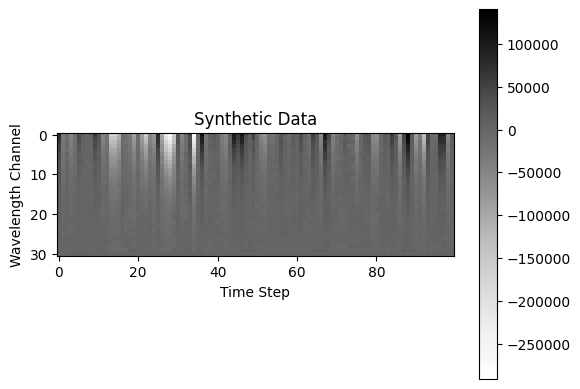

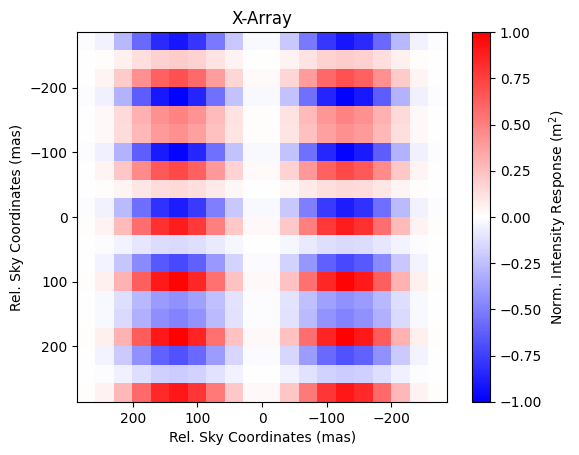

In [5]:
data = phringe.get_data()
intensity_response = phringe.get_intensity_response_torch('Earth')
wavelengths = [round(wavelength * 1e6, 1) for wavelength in wavelengths]
time_steps = [int(round(time, 0)) for time in time_steps.numpy()]
wavelength_index = 6
fov = (fov[wavelength_index] / 2) * 2.063e8
differential_ir = intensity_response[2, wavelength_index] - intensity_response[3, wavelength_index]
differential_ir /= torch.max(abs(differential_ir))

plt.imshow(data[0], cmap='Greys')
plt.title('Synthetic Data')
plt.ylabel('Wavelength Channel')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()

im = plt.imshow(differential_ir[0], cmap='bwr', extent=(fov, -fov, fov, -fov), vmin=-1, vmax=1)
plt.title('X-Array')
plt.xlabel('Rel. Sky Coordinates (mas)')
plt.ylabel('Rel. Sky Coordinates (mas)')
cb = plt.colorbar(im)
cb.set_label(label='Norm. Intensity Response (m$^2$)')
plt.show()

## Plot the Template Function
Plot the template function corresponding to the (ideal, i.e. unperturbed) signal of a planet at a certain position in the field of view. Use the initial flux for the template generation.

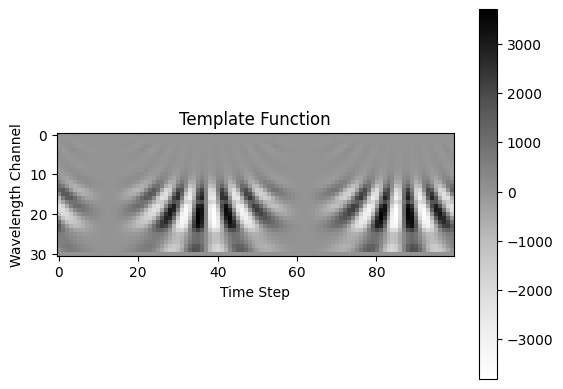

In [6]:
time = phringe.get_time_steps()
wavelength = phringe.get_wavelength_bin_centers()
pos_x = 3e-7  # rad
pos_y = 3e-7  # rad
flux = phringe.get_spectral_flux_density('Earth')
template = phringe.get_template_torch(time, wavelength, pos_x, pos_y, flux)

plt.imshow(template[0], cmap='Greys')
plt.title('Template Function')
plt.ylabel('Wavelength Channel')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()